In [1]:
import os.path

import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
train_dataset = pd.read_csv('../../data/processed/trainData.csv')
test_dataset = pd.read_csv('../../data/processed/trainData.csv')
synthetic_dataset = pd.read_csv('../../data/synthetic/SyntheticData.csv')

In [3]:
def preprocess_data(dataset):
    print(dataset)
    dataset = dataset.drop(['workclass','fnlwgt','education','marital-status','occupation','relationship','native-country'],axis=1)
    print(dataset.head)
    dataset['sex'] = np.where(dataset['sex'] == ' Male', 1, 0)
    dataset['race'] = np.where(dataset['race'] != ' White', 0, 1)
    dataset['Probability'] = np.where(dataset['Probability'] == ' <=50K', 0, 1)
    dataset['age'] = np.where(dataset['age'] >= 70, 70, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 60 ) & (dataset['age'] < 70), 60, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 50 ) & (dataset['age'] < 60), 50, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 40 ) & (dataset['age'] < 50), 40, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 30 ) & (dataset['age'] < 40), 30, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 20 ) & (dataset['age'] < 30), 20, dataset['age'])
    dataset['age'] = np.where((dataset['age'] >= 10 ) & (dataset['age'] < 10), 10, dataset['age'])
    dataset['age'] = np.where(dataset['age'] < 10, 0, dataset['age'])

    return dataset

In [4]:
print(synthetic_dataset)

        age          workclass  fnlwgt   education  education-num  \
0        42            Private  285787     HS-grad              9   
1        27            Private  103634     HS-grad              9   
2        22            Private  200593     HS-grad              9   
3        48   Self-emp-not-inc  246891     HS-grad              9   
4        36            Private  325374     HS-grad              9   
...     ...                ...     ...         ...            ...   
999995   40            Private  291300   Assoc-voc             11   
999996   45          Local-gov  334039   Bachelors             13   
999997   68   Self-emp-not-inc  195881   Bachelors             13   
999998   61        Federal-gov  161926        10th              6   
999999   45            Private  114459     HS-grad              9   

             marital-status          occupation    relationship  \
0             Never-married     Exec-managerial       Unmarried   
1             Never-married   Machine

In [5]:
train_dataset = preprocess_data(train_dataset)
print(train_dataset)
test_dataset = preprocess_data(test_dataset)
print(test_dataset)
synthetic_dataset = preprocess_data(synthetic_dataset)
print(synthetic_dataset)

       age          workclass  fnlwgt      education  education-num  \
0       52            Private  187938   Some-college             10   
1       43            Private  169628      Bachelors             13   
2       43   Self-emp-not-inc   89636      Bachelors             13   
3       32            Private  123291           12th              8   
4       32            Private   51150           12th              8   
...    ...                ...     ...            ...            ...   
36173   26            Private  177635           12th              8   
36174   21            Private  293968   Some-college             10   
36175   51          Local-gov  201040        Masters             14   
36176   53            Private  226135            9th              5   
36177   23            Private  315065           10th              6   

               marital-status          occupation    relationship  \
0                    Divorced               Sales   Not-in-family   
1        

In [6]:
from sklearn.preprocessing import MinMaxScaler

complete_dataset = pd.concat([train_dataset, synthetic_dataset])

scaler = MinMaxScaler()
scaler.fit(complete_dataset)
train_dataset = pd.DataFrame(scaler.transform(complete_dataset), columns = train_dataset.columns)
test_dataset = pd.DataFrame(scaler.transform(test_dataset), columns = train_dataset.columns)

## using FairSmote to generate datapoints in order to minimize bias

In [7]:
protected_attributes = ('sex', 'race')

negative_female_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]))
negative_female_white = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]))
negative_male_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]))
negative_male_white = (len(complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]))
positive_female_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]))
positive_female_white = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]))
positive_male_nonWhite = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]))
positive_male_white = (len(complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]))

maximum = max(negative_female_nonWhite, negative_female_white, negative_male_nonWhite, negative_male_white, positive_female_nonWhite, positive_female_white, positive_male_nonWhite, positive_male_white)

minimum = min(negative_female_nonWhite, negative_female_white, negative_male_nonWhite, negative_male_white, positive_female_nonWhite, positive_female_white, positive_male_nonWhite, positive_male_white)

#to retrieve value from counts follow this format : counts[outcome => 1 is positive 0 is negative][sex => 0 is female and 1 is male][race => 0 is non-white and 1 is white]
counts = [[[negative_female_nonWhite, negative_female_white], [negative_male_nonWhite, negative_male_white]], [[positive_female_nonWhite, positive_female_white], [positive_male_nonWhite, positive_male_white]]]

countarr = [counts[0][0][0], counts[0][0][1], counts[0][1][0], counts[0][1][1], counts[1][0][0], counts[1][0][1], counts[1][1][0], counts[1][1][1]]

countlabels = ['N-F-NW', 'N-F-W', 'N-M-NW', 'N-M-W', 'P-F-NW', 'P-F-W', 'P-M-NW', 'P-M-W']

for i in range(8):
    if countarr[i] is minimum:
        print(f"{countlabels[i]} is the minimum with {countarr[i]} datapoints")

P-F-NW is the minimum with 6552 datapoints


In [16]:
df_negative_female_nonWhite = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]
df_negative_female_white = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]
df_negative_male_nonWhite = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]
df_negative_male_white = complete_dataset[(complete_dataset['Probability'] == 0) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]
df_positive_female_nonWhite = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 0)]
df_positive_female_white = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 0) & (complete_dataset[protected_attributes[1]] == 1)]
df_positive_male_nonWhite = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 0)]
df_positive_male_white = complete_dataset[(complete_dataset['Probability'] == 1) & (complete_dataset[protected_attributes[0]] == 1) & (complete_dataset[protected_attributes[1]] == 1)]

dataframe_collection = [df_negative_female_nonWhite, df_negative_female_white, df_negative_male_nonWhite, df_negative_male_white, df_positive_female_nonWhite, df_positive_female_white, df_positive_male_nonWhite, df_positive_male_white]

for dataframe in dataframe_collection:
    dataframe['race'] = dataframe['race'].astype(str)
    dataframe['sex'] = dataframe['sex'].astype(str)

new_dataframe_collection = []

for dataframe in dataframe_collection:
    new_dataframe_collection.append(dataframe.sample(n=minimum))

/tmp/ipykernel_6364/238165786.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['race'] = dataframe['race'].astype(str)
/tmp/ipykernel_6364/238165786.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['sex'] = dataframe['sex'].astype(str)


In [17]:
df = pd.concat(new_dataframe_collection)
df

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,Probability
480240,20,9,0,0,0,0,30,0
912570,30,13,0,0,0,0,60,0
976435,17,6,0,0,0,1602,8,0
64957,50,9,0,0,0,0,40,0
45342,30,13,0,0,0,0,50,0
...,...,...,...,...,...,...,...,...
504042,40,7,1,1,0,0,70,1
61466,30,13,1,1,0,0,40,1
905949,20,15,1,1,0,0,50,1
734855,30,10,1,1,0,0,40,1


In [18]:
x_train, y_train = df.loc[:, df.columns != 'Probability'], df['Probability']
x_test, y_test = test_dataset.loc[:, test_dataset.columns != 'Probability'], test_dataset['Probability']

In [19]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

In [20]:
from sklearn.metrics import accuracy_score

print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.7509812593288739


In [21]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
logistic_classifier.fit(x_train, y_train)

y_pred_logistic = logistic_classifier.predict(x_test)

print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_logistic)))


Accuracy score: 0.7509812593288739


In [22]:
from sklearn.metrics import confusion_matrix



print(confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_test, y_pred_logistic))

[[27169     0]
 [ 9009     0]]
[[27169     0]
 [ 9009     0]]


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['<=50k', '>50k']))
print(classification_report(y_test, y_pred_logistic, target_names=['<=50k', '>50k']))

              precision    recall  f1-score   support

       <=50k       0.75      1.00      0.86     27169
        >50k       0.00      0.00      0.00      9009

    accuracy                           0.75     36178
   macro avg       0.38      0.50      0.43     36178
weighted avg       0.56      0.75      0.64     36178

              precision    recall  f1-score   support

       <=50k       0.75      1.00      0.86     27169
        >50k       0.00      0.00      0.00      9009

    accuracy                           0.75     36178
   macro avg       0.38      0.50      0.43     36178
weighted avg       0.56      0.75      0.64     36178



/home/roham_ml/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roham_ml/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roham_ml/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roham_ml/anaconda3/

/home/roham_ml/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/roham_ml/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


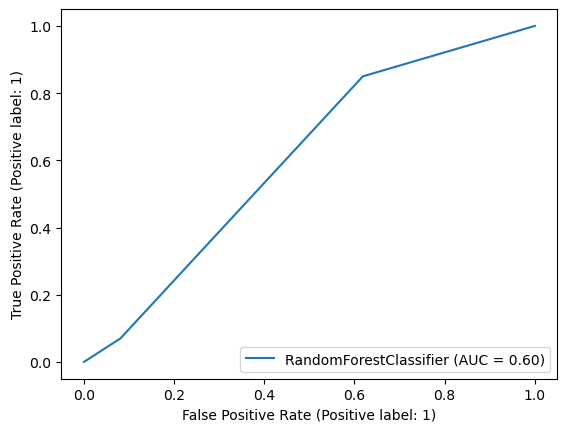

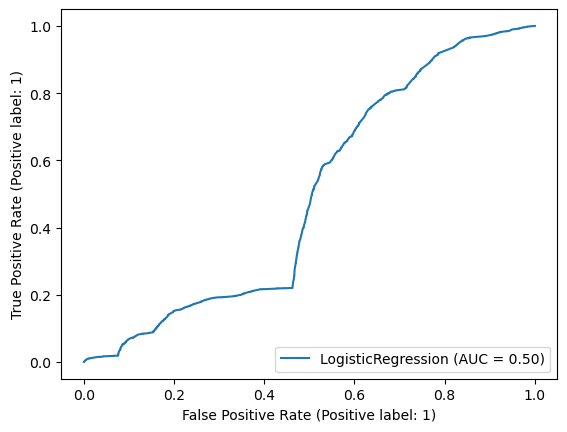

In [24]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(classifier, x_test, y_test)
plot_roc_curve(logistic_classifier, x_test, y_test)

In [ ]:
from Metrics import *

def get_allround_metrics(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes):

    print("recall :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'recall'))
    print("far :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'far'))
    print("precision :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'precision'))
    print("accuracy :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'accuracy'))
    print("F1 Score :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'F1'))
    print("aod :"+protected_attributes[0],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'aod'))
    print("eod :"+protected_attributes[0],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'eod'))

    print("SPD:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'SPD'))
    print("DI:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[0], 'DI'))

    print("-------------")

    print("recall :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'recall'))
    print("far :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'far'))
    print("precision :", measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'precision'))
    print("accuracy :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'accuracy'))
    print("F1 Score :",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'F1'))
    print("aod :"+protected_attributes[1],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'aod'))
    print("eod :"+protected_attributes[1],measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'eod'))

    print("SPD:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'SPD'))
    print("DI:",measure_final_score(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes[1], 'DI'))

print("\n\n\nmetrics for random forest classifier:")
get_allround_metrics(test_dataset, classifier, x_train, y_train, x_test, y_test, protected_attributes)

print("\n\n\nmetrics for Logistic regression:")
get_allround_metrics(test_dataset, logistic_classifier, x_train, y_train, x_test, y_test, protected_attributes)


/home/roham_ml/Desktop/meesterproef/code/GB_SMOTE/Metrics.py:139: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (TP + FN) is not 0:
/home/roham_ml/Desktop/meesterproef/code/GB_SMOTE/Metrics.py:147: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (FP + TN) is not 0:
/home/roham_ml/Desktop/meesterproef/code/GB_SMOTE/Metrics.py:155: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (TP + FP) is not 0:





metrics for random forest classifier:
recall : 0.0
far : 0.0


/home/roham_ml/Desktop/meesterproef/code/GB_SMOTE/Metrics.py:156: RuntimeWarning: invalid value encountered in long_scalars
  prec = TP / (TP + FP)


precision : nan
accuracy : 0.75


/home/roham_ml/Desktop/meesterproef/code/GB_SMOTE/Metrics.py:156: RuntimeWarning: invalid value encountered in long_scalars
  prec = TP / (TP + FP)


F1 Score : nan
aod :sex 0.0
eod :sex 0.0
SPD: 0.0
